In [1]:
pwd

'/private/home/dpf/projects/htlm_2/fairseq-py/notebooks'

In [2]:
root_folder = f'/private/home/dpf/projects/codex/'


In [14]:
cd '/private/home/dpf/projects/codex'

/private/home/dpf/projects/codex


In [3]:
import sys

In [4]:
sys.path.append(root_folder)

In [5]:
import glob
import pickle
import os

In [6]:
from models import Model

couldn't import torch; won't be able to use most models


In [7]:
import numpy as np

In [8]:
from human_eval.data import read_problems
from human_eval.evaluation import evaluate_functional_correctness

In [9]:
def unpickle(fname):
    print(fname)
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [10]:
def all_equal(xs):
    xs = list(xs)
    return [x == xs[0] for x in xs]

In [11]:
def combine_responses(list_of_responses):
    list_of_responses = list(list_of_responses)
    assert all_equal(resp.keys() for resp in list_of_responses)
    responses = {}
    for resp in list_of_responses:
        for problem_id in resp:
            if problem_id not in responses:
                responses[problem_id] = {'choices': []}
            responses[problem_id]['choices'].extend(resp[problem_id]['choices'])
    return responses

In [12]:
pdb on

Automatic pdb calling has been turned ON


In [17]:
temperature = 0.8
globs = f'expts/he/cm-6B-armen_last_ncg-20_temp-{temperature}/prompt_pyfile_unnormalized_max-128_s-*/responses.pkl'
# globs = f'out/cm-6B_it-best_ncg-20-1_temp-{temperature}/prompt-pyfile_s-*/responses.pkl'
# globs = f'out/lm-1.3B_it-last_ncg-20-1_temp-{temperature}/prompt-pyfile_s-*/responses.pkl'

In [18]:
responses = combine_responses(
    unpickle(fname) for fname in glob.glob(os.path.join(root_folder, globs))
)

/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_max-128_s-1/responses.pkl
/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_max-128_s-3/responses.pkl
/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_max-128_s-2/responses.pkl
/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_max-128_s-7/responses.pkl
/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_max-128_s-8/responses.pkl
/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_max-128_s-6/responses.pkl
/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_max-128_s-4/responses.pkl
/private/home/dpf/projects/codex/expts/he/cm-6B-armen_last_ncg-20_temp-0.8/prompt_pyfile_unnormalized_ma

In [20]:
len(next(iter(responses.values()))['choices'])

180

In [21]:
model = Model()

In [22]:
problems = list(sorted(read_problems().items()))

In [23]:
import random

In [54]:
def run_trial(responses, num_candidates, candidate_scoring):
    samples_to_evaluate = []
    for task_id, problem in problems:
        candidates = responses[task_id]['choices'].copy()
        random.shuffle(candidates)
        candidates = candidates[:num_candidates]
        completions, response = model.rank_completions(
            problem['prompt'], None, 
            cached_response={'choices': candidates},
            scoring=candidate_scoring,
        )
        best_candidate = completions[0]['text']
#         best_score, best_candidate = completions[0]
        samples_to_evaluate.append(dict(
            task_id=task_id,
            completion=best_candidate
        ))
    return evaluate_functional_correctness(
        sample_file=None, samples=samples_to_evaluate,
        n_workers=4, suppress=True, 
    )

In [25]:
def compute_oracle_scores(responses, all_num_candidates):
    samples_to_evaluate = []
    for task_id, problem in problems:
        choices = responses[task_id]['choices']
        assert max(all_num_candidates) <= len(choices), f"can't compute oracle; too few candidates ({len(choices)}) for id {task_id}"
        for choice in choices:
            samples_to_evaluate.append(dict(
                task_id=task_id, 
                completion=choice['text']
            ))
    results, extra = evaluate_functional_correctness(
        sample_file=None, samples=samples_to_evaluate,
        n_workers=20, suppress=False,
    )
    datapoints = []
    for num_candidates in all_num_candidates:
        datapoints.append({
            'num_candidates': num_candidates,
            'candidate_scoring': 'oracle',
            'pass@1': results[f'pass@{num_candidates}'],
        })
    return datapoints

In [26]:
datapoints = compute_oracle_scores(responses, [1, 10, 100])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29520/29520 [00:01<00:00, 23080.75it/s]


Running test suites...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29520/29520 [12:47<00:00, 38.47it/s]


In [56]:
# all_num_candidates = list(np.arange(9) + 1) + list((np.arange(10) + 1) * 10)
#all_num_candidates = [1, 10, 100]
all_num_candidates = [1, 2, 5, 10, 20, 50, 100]
all_num_candidates

[1, 2, 5, 10, 20, 50, 100]

In [57]:
from itertools import product

In [58]:
all_extras = {}
def log_trial(tpl):
    scoring_method, num_candidates, trial = tpl
    result, extras = run_trial(responses, num_candidates, scoring_method)
    result['num_candidates'] = num_candidates
    result['candidate_scoring'] = scoring_method
    result['trial'] = trial
    all_extras[tuple(tpl)] = extras
    return result

scoring_methods = ['sum', 'mean', 'random']
trials = list(range(3))

from multiprocessing.pool import ThreadPool
import tqdm
with ThreadPool(5) as pool:
    it = list(product(scoring_methods, all_num_candidates, trials))
    results = tqdm.tqdm(pool.imap(log_trial, it), total=len(it))
    datapoints.extend(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [05:17<00:00,  5.03s/it]


In [59]:
import pandas

In [60]:
df = pandas.DataFrame(datapoints)

In [61]:
df.columns

Index(['num_candidates', 'candidate_scoring', 'pass@1', 'trial'], dtype='object')

In [62]:
means = df.groupby(['num_candidates','candidate_scoring'])['pass@1'].mean()

In [63]:
import matplotlib.pyplot as plt

In [64]:
means

num_candidates  candidate_scoring
1               mean                 0.054878
                oracle               0.111247
                random               0.049797
                sum                  0.059959
2               mean                 0.073171
                random               0.054878
                sum                  0.064024
5               mean                 0.070122
                random               0.067073
                sum                  0.069106
10              mean                 0.071138
                oracle               0.279227
                random               0.056911
                sum                  0.086382
20              mean                 0.072154
                random               0.054878
                sum                  0.086382
50              mean                 0.075203
                random               0.048780
                sum                  0.073171
100             mean                 0.063008


Text(0, 0.5, 'Pass Rate')

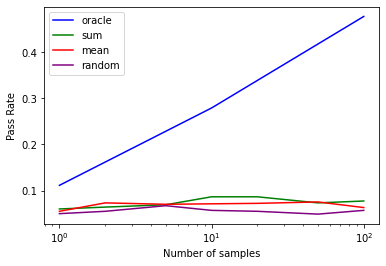

In [65]:
r = means.reset_index()
ax = None
for scoring, color in [('oracle', 'b'), ('sum', 'g'), ('mean', 'r'), ('random', 'purple')]:
    col = r[r['candidate_scoring'] == scoring]
    ax = col.plot(
        x='num_candidates', y='pass@1', color=color, label=scoring, logx=True,
        ax=ax,
    )
plt.legend()
plt.xlabel('Number of samples')
plt.ylabel('Pass Rate')
# plt.axhline(0.153, c='k', linestyle=':')

In [48]:
from collections import defaultdict

In [46]:
def pool_by_problem(all_extras, filter_fn=None):
    completion_lengths_by_problem = defaultdict(list)
    for tpl, d in all_extras.items():
        if filter_fn is not None and not filter_fn(tpl):
            continue
        for k, vs in d['completion_lengths'].items():
            completion_lengths_by_problem[k].extend(vs)
    return completion_lengths_by_problem

In [52]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras).items()}.values()))

312.78290747193194

In [56]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'random' and t[1] == 100).items()}.values()))

315.7073170731707

In [57]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'sum' and t[1] == 100).items()}.values()))

69.90650406504065

In [58]:
np.mean(list({k: np.mean(v) for k, v in pool_by_problem(all_extras, filter_fn=lambda t: t[0] == 'mean' and t[1] == 100).items()}.values()))

728.3983739837398